In [1]:
# from utils import process_ns3_csv
# input_filenames =  [
#     # '20241222_st-100_N-100_BH-40_SF-0_L-15_uni-1',
#     '20241119_st-100_N-50_BH-5_SF-0_L-15_uni-1',
#     '20241119_st-100_N-50_BH-10_SF-0_L-15_uni-1',
#     '20241119_st-100_N-50_BH-15_SF-0_L-15_uni-1',
#     '20241119_st-100_N-50_BH-20_SF-0_L-15_uni-1',
#     '20241119_st-100_N-100_BH-10_SF-0_L-20_uni-1',
#     '20241119_st-100_N-100_BH-20_SF-0_L-20_uni-1',
#     '20241119_st-100_N-100_BH-30_SF-0_L-20_uni-1',
#     '20241119_st-100_N-100_BH-40_SF-0_L-20_uni-1',
#     # 其他的 filenames...
# ]

# input_log_files = [
#     # '/log1222_uniform_1515_seed_23456.txt',
#     '/log1119_BH0.1_uniform_1515seed_12345.txt',
#     '/log1119_BH0.2_uniform_1515seed_12345.txt',
#     '/log1119_BH0.3_uniform_1515seed_12345.txt',
#     '/log1119_BH0.4_uniform_1515seed_12345.txt',
#     '/log1119_BH0.1_uniform_2020seed_12345.txt',
#     '/log1119_BH0.2_uniform_2020seed_12345.txt',
#     '/log1119_BH0.3_uniform_2020seed_12345.txt',
#     '/log1119_BH0.4_uniform_2020seed_12345.txt',
# ]



# for i in range(len(input_filenames)):
#     filename = input_filenames[i]
#     log_file = './dataset/' + filename + input_log_files[i]
#     input_file = './dataset/' + filename + '/MonitorSnifferRx.csv'
#     output_file = './dataset/' + filename + '/ProcessedMonitorSnifferRx_Time10.csv'
#     process_ns3_csv(input_file, output_file, log_file, 10)

In [2]:
from utils import load_data
import numpy as np
import models 
import csv
import matplotlib.pyplot as plt
import matplotlib
from utils import load_data
import models
from process_sniffer_hypergraph import *
import seaborn as sns
from torch_geometric.utils import scatter
import torch
import time
import torch.optim as optim
from utils import accuracy, auc, precision, recall
from utils import f1_score as f1
from utils import confusion_matrix as cm_utils
import torch.nn.functional as F
import pandas as pd
import os
from tqdm import tqdm
# torch.autograd.set_detect_anomaly(True)
import random
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as Sauc
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, f1_score

In [3]:
#验证集1
# np.set_printoptions(threshold=np.inf)  # 这将打印所有内容，去掉折叠
val_data_file ='./dataset/' + '20241119_st-100_N-100_BH-40_SF-0_L-20_uni-1' + '/ProcessedMonitorSnifferRx_Time10.csv'
val_processed_data, val_adj, val_T, val_group_num = load_data(1,val_data_file)
# print(train_processed_data[0].edge_attr)
edge_feature_size = val_processed_data[0].edge_attr.shape[1]
nodes_feature_size = val_processed_data[0].x.shape[1]

/home/wangchenlong/WWSNhypergraph/utils.py:519: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [4]:
#训练集1
# np.set_printoptions(threshold=np.inf)  # 这将打印所有内容，去掉折叠
data_file ='./dataset/' + '20241222_st-100_N-100_BH-40_SF-0_L-15_uni-1' + '/ProcessedMonitorSnifferRx_Time10.csv'
train_processed_data, train_adj, train_T, train_group_num = load_data(1,data_file)
# print(train_processed_data[0].edge_attr)
edge_feature_size = train_processed_data[0].edge_attr.shape[1]
nodes_feature_size = train_processed_data[0].x.shape[1]

In [5]:
#训练集2
# train_processed_data = []
# train_adj = []
# train_T = []
# for i in range(len(input_filenames)):
#     filename = input_filenames[i]
#     data_file = './dataset/' + filename + '/ProcessedMonitorSnifferRx_Time10.csv'
#     processed_data, adj, T, _ = load_data(1,data_file)
#     train_processed_data.append(processed_data[0])
#     train_adj.append(adj[0])
#     train_T.append(T[0])
# train_group_num = len(input_filenames)
# nodes_feature_size = train_processed_data[0].x.shape[1]
# edge_feature_size = train_processed_data[0].edge_attr.shape[1]

In [6]:
# 设置numpy的打印选项，显示更多行列


# 打印节点特征（processed_data.x.shape）
# print(train_processed_data[0].x)
# print(adj[12])
# print(T[12])

In [7]:
# 打印边连接关系（processed_data.edge_index）
# print(processed_data[-1].edge_index.numpy().size)

In [8]:
# 打印节点标签（processed_data.y）
np.set_printoptions(threshold=np.inf)
# print(processed_data[0].y.numpy())
# print(processed_data[0].x[:, 0:23].numpy())
# print(processed_data[5].y.numpy())
# print(processed_data[5].edge_index)
# print(processed_data[5].edge_weights)
# print(processed_data[5].x.numpy())

In [9]:

# train_model = models.HypergraphModel(nodes_feature_size, edge_feature_size)
# train_model = models.GATModel(nodes_feature_size, edge_feature_size, 64)
train_model = models.HypergraphModel(nodes_feature_size, edge_feature_size, 128)
print(train_model)
# 查看可用的 GPU 数量
num_gpus = torch.cuda.device_count()
print(f"Available GPUs: {num_gpus}")

# 打印每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model = train_model.to(device)

HypergraphModel(
  (layer1): HypergraphConvLayer(
    (conv): HypergraphConv(3, 128)
  )
  (layer2): HypergraphConvLayer(
    (conv): HypergraphConv(128, 128)
  )
  (edge_conv): GraphConvolution()
  (class_classifier): Sequential(
    (0): Linear(in_features=128, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
  (norm1): CustomBatchNorm()
  (norm2): CustomBatchNorm()
)
Available GPUs: 1
GPU 0: NVIDIA A100 80GB PCIe


In [10]:

criteria = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 5e-4
optimizer = optim.Adam(train_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
acc_measure = accuracy
train_end_index = train_group_num
print(train_end_index)
val_index = train_group_num - 1

def adj_matrix_to_edge_index(adj_matrix):
    # 如果是稀疏矩阵，先转换为密集矩阵
    if adj_matrix.is_sparse:
        adj_matrix = adj_matrix.to_dense()
    
    # 获取非零元素的位置
    row, col = adj_matrix.nonzero(as_tuple=True)
    
    # 组合为 edge_index
    edge_index = torch.stack([row, col], dim=0)
    return edge_index
    
def train(epoch, save_path, train_loss_list, val_loss_list):
    t = time.time()
    train_model.train()
    optimizer.zero_grad()
    # print(processed_data[0].x[0:23].shape)
    # print(processed_data[0].edge_weights.shape)
    # print(processed_data[0].edge_index.shape)

    each_epoch_loss_train = 0
    each_epoch_loss_val = 0
    for i in range(0, train_end_index):
        # print(i)
        labels = train_processed_data[i].y.to(device)
        output = train_model(train_processed_data[i].x.to(device),
                             train_processed_data[i].edge_index.to(device), 
                             train_processed_data[i].edge_weights.to(device), 
                             train_processed_data[i].edge_attr.to(device), 
                             train_adj[i].to(device),
                             train_T[i].to(device))
        # print(output)
        # print(output)
        
        loss_train = criteria(output, labels)
        each_epoch_loss_train = each_epoch_loss_train + loss_train.item()
        # print(output[:, 1])
        acc_train = acc_measure(output, labels)
        
        loss_train.backward(retain_graph=True)
        optimizer.step()
        
        
    train_model.eval()
    for i in range(0, 3):
        val_index = i
        val_labels = val_processed_data[val_index].y.to(device)
        val_output = train_model(val_processed_data[val_index].x.to(device),
                             val_processed_data[val_index].edge_index.to(device), 
                             val_processed_data[val_index].edge_weights.to(device),
                             val_processed_data[val_index].edge_attr.to(device),
                             val_adj[val_index].to(device),
                             val_T[val_index].to(device))
        # print(output)
        
        loss_val = criteria(val_output, val_labels)
        each_epoch_loss_val = each_epoch_loss_val + loss_val.item()
        
        acc_val = acc_measure(val_output, val_labels)
        auc_val = auc(val_output, val_labels)
        per_val = precision(val_output, val_labels)
        recall_val = recall(val_output, val_labels)
        f1_val = f1(val_output, val_labels)
        # print(
        #     'loss_train: {:.4f}'.format(loss_train.item()),
        #     'acc_train: {:.4f}'.format(acc_train.item()),
        #     'loss_val: {:.4f}'.format(loss_val.item()),
        #     'acc_val: {:.4f}'.format(acc_val.item()),
        #     'auc_val: {:.4f}'.format(auc_val),
        #     'per_val: {:.4f}'.format(per_val),
        #     'recall_val: {:.4f}'.format(recall_val),
        #     'f1_val: {:.4f}'.format(f1_val),
        #     'time: {:.4f}s'.format(time.time() - t))
    train_loss_list.append(each_epoch_loss_train / (train_end_index))
    val_loss_list.append(each_epoch_loss_val / 3)
    
    # 每个 epoch 结束后保存模型
    torch.save(train_model.state_dict(), save_path)
    # torch.save({
    #     'epoch': epoch,
    #     'model_state_dict': train_model.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     }, save_path)
    # print(f'Model saved to {save_path}')

    return loss_val.item()


11


In [11]:

filename = '20241119_st-100_N-50_BH-5_SF-0_L-15_uni-1'
test_data_file = './dataset/' + filename + '/ProcessedMonitorSnifferRx_Time10.csv'

test_data, test_adj, test_T, test_group_num = load_data(1,test_data_file)
# print(processed_data[0].edge_attr)
end_index = 3
print(end_index)
best_metrics_history = []
top_k = 10  # 选择前10个最佳的指标值

filenames = [
    # '20241119_st-100_N-50_BH-5_SF-0_L-15_uni-1',
    # '20241119_st-100_N-50_BH-10_SF-0_L-15_uni-1',
    # '20241119_st-100_N-50_BH-15_SF-0_L-15_uni-1',
    # '20241119_st-100_N-50_BH-20_SF-0_L-15_uni-1',
    # '20241119_st-100_N-100_BH-10_SF-0_L-20_uni-1',
    # '20241119_st-100_N-100_BH-20_SF-0_L-20_uni-1',
    '20241119_st-100_N-100_BH-30_SF-0_L-20_uni-1',
    # '20241119_st-100_N-100_BH-40_SF-0_L-20_uni-1',
    # 其他的 filenames...
]
num_metrics = len(filenames)

dataset_results = {
    'losses': [[[] for _ in range(end_index)] for _ in range(num_metrics)],  # 多维，记录每个数据集的多个loss值
    'accuracies': [[[] for _ in range(end_index)] for _ in range(num_metrics)],
    'aucs': [[[] for _ in range(end_index)] for _ in range(num_metrics)],
    'precisions': [[[] for _ in range(end_index)] for _ in range(num_metrics)],
    'recalls': [[[] for _ in range(end_index)] for _ in range(num_metrics)],
    'f1_scores': [[[] for _ in range(end_index)] for _ in range(num_metrics)],
    'TP': [[[] for _ in range(end_index)] for _ in range(num_metrics)],
    'FP': [[[] for _ in range(end_index)] for _ in range(num_metrics)],
    'TN': [[[] for _ in range(end_index)] for _ in range(num_metrics)],
    'FN': [[[] for _ in range(end_index)] for _ in range(num_metrics)],
    'outputs': [[[] for _ in range(end_index)] for _ in range(num_metrics)],
    'labels': [[[] for _ in range(end_index)] for _ in range(num_metrics)],
}

final_results = {
        'losses': [[] for _ in range(num_metrics)],
        'accuracies': [[] for _ in range(num_metrics)],
        'aucs': [[] for _ in range(num_metrics)],
        'precisions': [[] for _ in range(num_metrics)],
        'recalls': [[] for _ in range(num_metrics)],
        'f1_scores': [[] for _ in range(num_metrics)],
        'TP': [[] for _ in range(num_metrics)],
        'FP': [[] for _ in range(num_metrics)],
        'TN': [[] for _ in range(num_metrics)],
        'FN': [[] for _ in range(num_metrics)],
    }

def get_top_k_avg(metric_list, top_k=top_k):
    return np.mean(sorted(metric_list, reverse=True)[:top_k])


        
def test(testfilename):
    test_data_file = './dataset/' + testfilename + '/ProcessedMonitorSnifferRx_Time10.csv'
    test_data, test_adj, test_T, test_group_num = load_data(1,test_data_file)
    
    train_model.eval()
    all_preds = []
    all_labels = []
    for i in range(end_index):
        labels = test_data[test_group_num-1].y.to(device)
        output = train_model(test_data[i].x.to(device),
                             test_data[i].edge_index.to(device).to(device), 
                             test_data[i].edge_weights.to(device),
                             test_data[i].edge_attr.to(device),
                             test_adj[i].to(device),
                             test_T[i].to(device))
        
        # print(output)
        # print(labels)
        output_copy = output.detach().clone()  # 复制并分离梯度
        all_preds.append(output_copy.cpu().numpy().argmax(axis=1))
        all_labels.append(test_data[i].y.cpu().numpy())
        loss_test = criteria(output, labels)
        acc_test = acc_measure(output, labels)
        auc_test = auc(output, labels)
        per_test = precision(output, labels)
        recall_test = recall(output, labels)
        f1_test = f1(output, labels)
        tp, tn, fp, fn = cm_utils(output, labels)

        # 将当前指标添加到相应的数据集列表中
        dataset_results['losses'][filenames.index(testfilename)][i].append(loss_test.item())
        dataset_results['accuracies'][filenames.index(testfilename)][i].append(acc_test.item())
        dataset_results['aucs'][filenames.index(testfilename)][i].append(auc_test)
        dataset_results['precisions'][filenames.index(testfilename)][i].append(per_test)
        dataset_results['recalls'][filenames.index(testfilename)][i].append(recall_test)
        dataset_results['f1_scores'][filenames.index(testfilename)][i].append(f1_test)
        dataset_results['TP'][filenames.index(testfilename)][i].append(tp)
        dataset_results['FP'][filenames.index(testfilename)][i].append(fp)
        dataset_results['TN'][filenames.index(testfilename)][i].append(tn)
        dataset_results['FN'][filenames.index(testfilename)][i].append(fn)
        dataset_results['outputs'][filenames.index(testfilename)][i].append(output)
        dataset_results['labels'][filenames.index(testfilename)][i].append(labels)
        
        # print(
        #     "Dataset " +
        #     str(filenames.index(testfilename)) +
        #     " Test set " +
        #     str(i) +
        #     " results:",
        #     "loss= {:.4f}".format(loss_test.item()),
        #     "accuracy= {:.4f}".format(acc_test.item()),
        #     'auc_test: {:.4f}'.format(auc_test),
        #     'per_test: {:.4f}'.format(per_test),
        #     'recall_test: {:.4f}'.format(recall_test),
        #     'f1_test: {:.4f}'.format(f1_test))
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_labels = np.argmax(all_labels, axis=1)
    accuracy_all = accuracy_score(all_labels, all_preds)
    precision_all = precision_score(all_labels, all_preds, average='binary', pos_label=1)
    recall_all = recall_score(all_labels, all_preds, average='binary', pos_label=1)
    f1_all = f1_score(all_labels, all_preds, average='binary', pos_label=1)

    results_file = './dataset/' + testfilename + "/hypergraph_realworld_evaluation_results.txt"

    # 检查文件是否存在，如果不存在则创建并添加表头
    if not os.path.exists(results_file):
        with open(results_file, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(["文件名", "准确率", "精确率", "召回率", "F1", "epoch"])
    
    # 追加评估结果
    with open(results_file, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow([testfilename, f"{accuracy_all:.4f}", f"{precision_all:.4f}", f"{recall_all:.4f}", f"{f1_all:.4f}", f"{epoch:.4f}",])
    # print(f'评估 - 准确率: {accuracy_all:.4f}, 精确率: {precision_all:.4f}, 召回率: {recall_all:.4f}, F1: {f1_all:.4f}')

    # 添加当前结果
    best_metrics_history.append({
        'epoch': epoch,
        'accuracy': accuracy_all,
        'precision': precision_all,
        'recall': recall_all,
        'f1': f1_all
    })

    # 混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)

    # 原标签名称（保持一致）
    original_labels = ['Normal Node', 'Malicious Node']

    # 交换后的标签顺序
    labels = ['Malicious Node', 'Normal Node']  # 交换顺序

    # 转换为 DataFrame，保持原顺序
    cm_df = pd.DataFrame(cm, index=original_labels, columns=original_labels)

    # 交换行和列的顺序
    cm_swapped = cm_df.loc[labels, labels]
    save_dir = './dataset/' + testfilename + "/node_confusion_matrices_hypergraph_realworld"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if epoch % 50 == 0:
        plt.rcParams.update({
            'font.family': 'Times New Roman',
            'font.size': 30,
            'axes.titlesize': 30,
            'axes.labelsize': 30,
            'xtick.labelsize': 15,
            'ytick.labelsize': 15
        })
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm_swapped, annot=True, fmt='d', cmap='Blues', cbar=False)

        plt.xlabel('Predicted Labels', fontsize=15)
        plt.ylabel('True Labels', fontsize=15)
        plt.savefig(os.path.join(save_dir, f"node_cm_epoch_{epoch}_hypergraph.pdf"))
        plt.close()
    return acc_test.item()


def get_top_k_AVEresult(testfilename):
    k=10
    # Extract the best k F1-scores and corresponding indices
    best_f1_indices = []
    idx = filenames.index(testfilename)
    
    for dataset_f1s in dataset_results['f1_scores'][idx]:
        # Get the indices of the top k F1 values
        top_k_indices = sorted(range(len(dataset_f1s)), key=lambda i: dataset_f1s[i], reverse=True)[:k]
        print(f"Top-{k} indices for F1 in dataset: {top_k_indices}")
        best_f1_indices.append(top_k_indices)

    # Collect metrics for the top k F1-score results
    for i, top_k_indices in enumerate(best_f1_indices):
        for metric in ['losses', 'accuracies', 'precisions', 'recalls', 'f1_scores', 'TP', 'FP', 'TN', 'FN']:
            values = [dataset_results[metric][idx][i][j] for j in top_k_indices]
            final_results[metric][idx].append(sum(values) / len(values))
        # Also store the AUC for completeness
        auc_values = [dataset_results['aucs'][idx][i][j] for j in top_k_indices]
        final_results['aucs'][idx].append(sum(auc_values) / len(auc_values))

    # Print the final results
    print(f"\nFinal results (average of top {k} highest F1-score for each dataset):")
    for i in range(end_index):
        print(f"Dataset {i + 1}:")
        print(f"  Average loss: {final_results['losses'][idx][i]:.4f}")
        print(f"  Average accuracy: {final_results['accuracies'][idx][i]:.4f}")
        print(f"  Average AUC: {final_results['aucs'][idx][i]:.4f}")
        print(f"  Average Precision: {final_results['precisions'][idx][i]:.4f}")
        print(f"  Average Recall: {final_results['recalls'][idx][i]:.4f}")
        print(f"  Average F1-score: {final_results['f1_scores'][idx][i]:.4f}")
        print()

    # Write the results to file
    output_file = './dataset/' + testfilename + '/hypergraph_result.txt'
    with open(output_file, 'a') as f:
        f.write("Test Results:\n")
        f.write("="*80 + "\n")
        f.write(f"\nFinal results {testfilename} (average of top {k} highest F1-score for each dataset):\n")
        for i in range(end_index):
            f.write(f"Dataset {i + 1}:\n")
            f.write(f"  Average loss: {final_results['losses'][idx][i]:.4f}\n")
            f.write(f"  Average accuracy: {final_results['accuracies'][idx][i]:.4f}\n")
            f.write(f"  Average AUC: {final_results['aucs'][idx][i]:.4f}\n")
            f.write(f"  Average Precision: {final_results['precisions'][idx][i]:.4f}\n")
            f.write(f"  Average Recall: {final_results['recalls'][idx][i]:.4f}\n")
            f.write(f"  Average F1-score: {final_results['f1_scores'][idx][i]:.4f}\n")
            f.write(f"  Average TP: {final_results['TP'][idx][i]:.4f}\n")
            f.write(f"  Average FP: {final_results['FP'][idx][i]:.4f}\n")
            f.write(f"  Average TN: {final_results['TN'][idx][i]:.4f}\n")
            f.write(f"  Average FN: {final_results['FN'][idx][i]:.4f}\n")
            f.write("-"*80 + "\n")

3


In [12]:



# 固定随机数种子
# def set_seed(seed):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# set_seed(9252)


num_epochs = 1000
early_stopping = 3000
val_watch = []
t_total = time.time()
current_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())


save_path = './models/hnff/' + current_time + '/' + current_time + '.pth'
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # 创建目录，如果目录已存在不抛出错误

train_loss_list = []
val_loss_list = []       
for epoch in tqdm(range(num_epochs), desc="Training Epochs", unit="epoch"):
    
    val = train(epoch, save_path, train_loss_list, val_loss_list)  # 训练并获得结果
    if val is None:  # 检查是否返回了None值
        print(f"Warning: train(epoch) returned None for epoch {epoch}. Skipping this iteration.")
        continue
    
    val_watch.append(val)  # 将结果添加到val_watch
    # if ((num_epochs - epoch) < 30):
    for filename in filenames:
        test(filename)  # 调用测试函数


        
for filename in filenames:
    get_top_k_AVEresult(filename)
    testfilename = filename
    # if epoch > early_stopping and val_watch[-1] > np.mean(val_watch[-(early_stopping + 1):-1]):
    #     print("Early stopping...")
    #     break



best_metrics_history = sorted(best_metrics_history[-100:], key=lambda x: x['f1'], reverse=True)[:10]
# 计算平均值
avg_metrics = {
    'accuracy': np.mean([m['accuracy'] for m in best_metrics_history]),
    'precision': np.mean([m['precision'] for m in best_metrics_history]),
    'recall': np.mean([m['recall'] for m in best_metrics_history]),
    'f1': np.mean([m['f1'] for m in best_metrics_history])
}

# 写入CSV

csv_path = './dataset/' + testfilename + "/node_confusion_matrices_hypergraph_realworld/node_level_metrics_hypergraph.csv"
file_exists = os.path.isfile(csv_path)
with open(csv_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    if not file_exists:
        writer.writerow(['Epoch', 'Model', 'Avg Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1'])
    writer.writerow([
        epoch,
        round(avg_metrics['accuracy'], 4),
        round(avg_metrics['precision'], 4),
        round(avg_metrics['recall'], 4),
        round(avg_metrics['f1'], 4)
    ])


print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print("Printing the weights : ")

Training Epochs:   1%|█                                                                                                              | 10/1000 [00:28<44:08,  2.67s/epoch]/home/wangchenlong/anaconda3/envs/hypergraph/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Epochs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [32:55<00:00,  1.98s/epoch]

Top-10 indices for F1 in dataset: [218, 221, 171, 262, 836, 161, 215, 419, 487, 846]
Top-10 indices for F1 in dataset: [233, 221, 456, 885, 171, 196, 133, 139, 152, 155]
Top-10 indices for F1 in dataset: [845, 133, 171, 315, 413, 446, 463, 487, 846, 136]

Final results (average of top 10 highest F1-score for each dataset):
Dataset 1:
  Average loss: 0.3539
  Average accuracy: 0.9212
  Average AUC: 0.9102
  Average Precision: 0.9146
  Average Recall: 0.8167
  Average F1-score: 0.8626

Dataset 2:
  Average loss: 0.3934
  Average accuracy: 0.8788
  Average AUC: 0.8817
  Average Precision: 0.8511
  Average Recall: 0.7367
  Average F1-score: 0.7864

Dataset 3:
  Average loss: 0.3805
  Average accuracy: 0.8859
  Average AUC: 0.8748
  Average Precision: 0.8367
  Average Recall: 0.7767
  Average F1-score: 0.8049

Optimization Finished!
Total time elapsed: 1975.3405s
Printing the weights : 


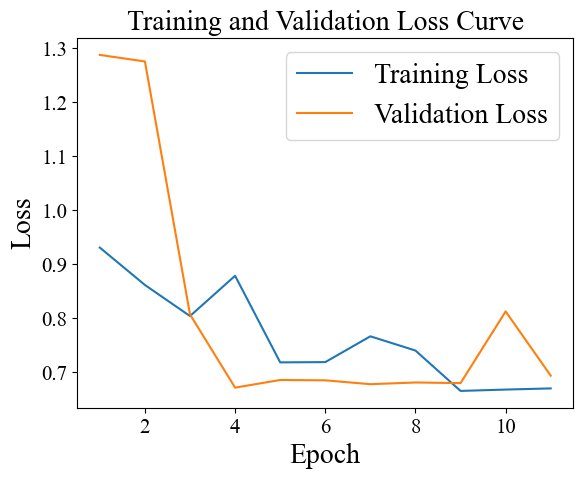

In [13]:

# 绘制损失曲线
# print(train_loss_list)
# print(val_loss_list
plt.rc('font', family='Times New Roman')
plot_train_loss_list = train_loss_list
plot_val_loss_list = val_loss_list
plt.plot(range(1, 11+1), plot_train_loss_list[:11], label='Training Loss')
plt.plot(range(1, 11+1), plot_val_loss_list[:11], label='Validation Loss')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Training and Validation Loss Curve', fontsize=20)
plt.legend(fontsize=20)
save_path = f"./dataset/lossFig/trainvalloss500_8.pdf"
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if it doesn't exist
plt.savefig(save_path, bbox_inches='tight')
plt.show()

plt.close()

In [14]:

linestyles = ['-', '--',  '-.', '-', '--', ':', '-.']
markers = ['o', 's', '^', 'D', 'p', 'H', 'x', '+']  # 用于区分不同曲线的标记样式Y
def plot_highest_auc_per_dataset(dataset_results, save_path_prefix):
    """
    Plot and save the ROC curve for the highest AUC in each dataset.

    Parameters:
    dataset_results (dict): The dictionary containing AUCs and corresponding outputs/labels.
    save_path_prefix (str): The prefix for the file paths to save the ROC curve images.
    """
    for dataset_idx, aucs in enumerate(dataset_results['aucs']):
        # print(len(aucs))
        best_outputs = []
        best_labels = []
        # Find the highest AUC in the current dataset
        for test_idx, auc_list in enumerate(aucs):
            highest_auc = 0
            
            if test_idx > 2:
                break
            for i, auc_val in enumerate(auc_list):
                if (auc_val > highest_auc):
                    highest_auc = auc_val
                    best_output = dataset_results['outputs'][dataset_idx][test_idx][i]
                    best_label = dataset_results['labels'][dataset_idx][test_idx][i]


            best_outputs.append(best_output)
            best_labels.append(best_label)
        
        for i in range(len(best_outputs)):
            output = best_outputs[i]
            labels = best_labels[i]
            # print(best_outputs)
            # print(len(best_labels))
    
            # Ensure output is in probability format (if it's logits, apply softmax/sigmoid)
            if output.ndim > 1 and output.shape[1] > 1:  # Multi-class case (not expected for binary)
                probabilities = torch.nn.functional.softmax(output, dim=1)[:, 1].detach().cpu().numpy()
            else:  # Binary case
                probabilities = torch.sigmoid(output).detach().cpu().numpy()
    
            # Ensure labels are binary (0 or 1) and one-dimensional
            if labels.ndim > 1:
                labels = labels.argmax(dim=1)  # Convert one-hot to class indices
            labels = labels.detach().cpu().numpy()
    
            # Compute ROC curve and AUC
            fpr, tpr, _ = roc_curve(labels, probabilities)
            roc_auc = Sauc(fpr, tpr)
    
            # Plot the ROC curve for the current small dataset
            plt.plot(fpr, tpr, lw=2, linestyle=linestyles[i % len(linestyles)],
                     marker=markers[i % len(markers)], markersize=8, 
                     alpha=0.8, 
                     label=f'Simulation time: {i}0-{i+1}0s (AUC = {roc_auc:.2f})')
    
        # Plot diagonal line (random guess line)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
        # Set labels and title
        plt.xlabel('False Positive Rate', fontsize=20)
        plt.ylabel('True Positive Rate', fontsize=20)
        plt.title(f'ROC Curves', fontsize=24)
    
        # Set tick parameters
        plt.tick_params(axis='both', labelsize=15)
    
        # Add legend
        plt.legend(loc="lower right", fontsize=14)
    
        # Save the figure as a PDF
        save_path = f"./dataset/rocCurve/{save_path_prefix}_dataset{filenames[dataset_idx]}_highest_auc.pdf"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if it doesn't exist
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    
        print(f"ROC curves for dataset {dataset_idx} saved to {save_path}.")


plot_highest_auc_per_dataset(dataset_results, '/roc_curves_20241223timenewroman')

ROC curves for dataset 0 saved to ./dataset/rocCurve//roc_curves_20241223timenewroman_dataset20241119_st-100_N-100_BH-30_SF-0_L-20_uni-1_highest_auc.pdf.


In [15]:

# plot_highest_auc_per_dataset(dataset_results, '/roc_curves_20241222')

In [16]:
# import torch
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc as Sauc
# import numpy as np

# def plot_roc_for_multiple_datasets(dataset_results, save_path_prefix, test_idx_list, colors):
#     """
#     Plot and save ROC curves for specified test_idx across multiple datasets with different colors.

#     Parameters:
#     dataset_results (dict): The dictionary containing AUCs, outputs, and labels for each dataset.
#     save_path_prefix (str): The prefix for the file paths to save the ROC curve images.
#     test_idx_list (list): List of test_idx (small datasets) to be plotted on the same graph.
#     colors (list): A list of colors for each dataset's ROC curve.
#     """
#     for test_idx in test_idx_list:
#         plt.figure(figsize=(10, 8))  # Set figure size
#         print(len(dataset_results['aucs']))
#         # Iterate over datasets and plot ROC curves for the specified test_idx
#         for dataset_idx in range(len(dataset_results['aucs'])):
#             auc_list = dataset_results['aucs'][dataset_idx]  # Get AUC list for this dataset
            
#             # Check if the test_idx is valid
#             if test_idx < len(auc_list):
#                 auc_val = auc_list[test_idx]
#                 output = dataset_results['outputs'][dataset_idx][test_idx]
#                 labels = dataset_results['labels'][dataset_idx][test_idx]
                
#                 # Ensure output is in probability format (if it's logits, apply softmax/sigmoid)
#                 if output.ndim > 1 and output.shape[1] > 1:  # Multi-class case (not expected for binary)
#                     probabilities = torch.nn.functional.softmax(output, dim=1)[:, 1].detach().cpu().numpy()
#                 else:  # Binary case
#                     probabilities = torch.sigmoid(output).detach().cpu().numpy()

#                 # Ensure labels are binary (0 or 1) and one-dimensional
#                 if labels.ndim > 1:
#                     labels = labels.argmax(dim=1)  # Convert one-hot to class indices
#                 labels = labels.detach().cpu().numpy()

#                 # Compute ROC curve and AUC
#                 fpr, tpr, _ = roc_curve(labels, probabilities)
#                 roc_auc = Sauc(fpr, tpr)

#                 # Plot ROC curve for this dataset with a unique color for each dataset
#                 plt.plot(fpr, tpr, lw=2, label=f'Dataset {dataset_idx} (AUC = {roc_auc:.2f})', color=colors[dataset_idx])

#         # Plot diagonal line (random guess line)
#         plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

#         # Set labels and title
#         plt.xlabel('False Positive Rate', fontsize=20)
#         plt.ylabel('True Positive Rate', fontsize=20)
#         plt.title(f'ROC Curves for Test {test_idx} Across Datasets', fontsize=24)

#         # Set tick parameters
#         plt.tick_params(axis='both', labelsize=15)

#         # Add legend
#         plt.legend(loc="lower right")

#         # Save the figure as a PDF
#         save_path = f"{save_path_prefix}_test_{test_idx}_roc_curve.pdf"
#         plt.savefig(save_path, format='pdf')
#         plt.close()


# def plot_all_roc_curves(dataset_results, save_path_prefix):
#     """
#     Plot and save the ROC curves for each test_idx across multiple datasets.
#     This function calls plot_roc_for_multiple_datasets for each test_idx.

#     Parameters:
#     dataset_results (dict): The dictionary containing AUCs, outputs, and labels for each dataset.
#     save_path_prefix (str): The prefix for the file paths to save the ROC curve images.
#     """
#     # Define colors for each dataset's ROC curve (you can change these colors as needed)
#     colors = plt.cm.get_cmap('tab10', len(dataset_results['aucs']))  # 'tab10' colormap for up to 10 datasets
#     colors = [colors(i) for i in range(len(dataset_results['aucs']))]

#     test_idx_groups = [
#         [0, 1, 2],  # Group for test 1 (small datasets 1, 5, 9)
#         [3, 4, 5],  # Group for test 2 (small datasets 2, 6, 10)
#         [6, 7],     # Group for test 3 (small datasets 3, 7)
#         [8, 9]      # Group for test 4 (small datasets 4, 8)
#     ]
    
#     # Plot ROC curves for each group of test_idx
#     for group_idx, test_idx_list in enumerate(test_idx_groups):
#         plot_roc_for_multiple_datasets(dataset_results, save_path_prefix, test_idx_list, colors)